Analytics Anonymous Data Cleaning and Validation

Here in this notebook we are going to be cleaning our kaggle data set, removing outliers and preparing data for future analysis.


In [2]:
import kagglehub
import os
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("jacksoncrow/stock-market-dataset")

print("Path to dataset files:", path)
files = os.listdir(path)
print("Files in dataset:", files)

csv_path = os.path.join(path, "symbols_valid_meta.csv")

df = pd.read_csv(csv_path)
print("Here is the head of the dataframe:")
print(df.head())
print("Here is the info of the data frame:")
print(df.info())

Path to dataset files: /Users/paulfynnkuemmel/.cache/kagglehub/datasets/jacksoncrow/stock-market-dataset/versions/2
Files in dataset: ['symbols_valid_meta.csv', 'stocks', 'etfs']
Here is the head of the dataframe:
  Nasdaq Traded Symbol                                      Security Name  \
0             Y      A            Agilent Technologies, Inc. Common Stock   
1             Y     AA                    Alcoa Corporation Common Stock    
2             Y   AAAU                       Perth Mint Physical Gold ETF   
3             Y   AACG  ATA Creativity Global - American Depositary Sh...   
4             Y   AADR                AdvisorShares Dorsey Wright ADR ETF   

  Listing Exchange Market Category ETF  Round Lot Size Test Issue  \
0                N                   N           100.0          N   
1                N                   N           100.0          N   
2                P                   Y           100.0          N   
3                Q               G   N         

So, what we can see from this, including by observation through the data file, we have multiple CSVs one per each individual stock or ETF. Which means we need to make some decisions when it comes to our analysis of the data. We are studying if we can use hybrid technical approaches to determine whether or not we can predict the volatility of the S&P 500, and so, we will be selecting this as our data set. In this case, we can find this as multiple ETFs that track the S&P. We will be selecting 5 of them to use these representatives of the market.

In [4]:
etfs = df[df['ETF'] == 'Y']
print("Number of ETFs:", len(etfs))
print(etfs[['Symbol', 'Security Name']].head(20))

Number of ETFs: 2165
    Symbol                                      Security Name
2     AAAU                       Perth Mint Physical Gold ETF
4     AADR                AdvisorShares Dorsey Wright ADR ETF
16    AAXJ  iShares MSCI All Country Asia ex Japan Index Fund
24    ABEQ                         Absolute Core Strategy ETF
45    ACES                              ALPS Clean Energy ETF
53    ACIO  ETF Series Solutions Aptus Collared Income Opp...
66    ACSG  Xtrackers MSCI ACWI ex USA ESG Leaders Equity ETF
67    ACSI                 American Customer Satisfaction ETF
69     ACT                             AdvisorShares Vice ETF
75    ACWF           iShares Edge MSCI Multifactor Global ETF
76    ACWI                       iShares MSCI ACWI Index Fund
77    ACWV               iShares Edge MSCI Min Vol Global ETF
78    ACWX                 iShares MSCI ACWI ex US Index Fund
88    ADME                  Aptus Drawdown Managed Equity ETF
94    ADRE   Invesco BLDRS Emerging Markets 50 AD

In [5]:
sp500_etfs = etfs[etfs['Security Name'].str.contains("S&P 500", case=False, na=False)]
print(sp500_etfs[['Symbol', 'Security Name']])

     Symbol                                      Security Name
620    BAPR              Innovator S&P 500 Buffer ETF - April 
627    BAUG              Innovator S&P 500 Buffer ETF - August
691    BDEC            Innovator S&P 500 Buffer ETF - December
715    BFEB            Innovator S&P 500 Buffer ETF - February
780    BJAN             Innovator S&P 500 Buffer ETF - January
...     ...                                                ...
7621    VOO                               Vanguard S&P 500 ETF
7622   VOOG                        Vanguard S&P 500 Growth ETF
7623   VOOV                         Vanguard S&P 500 Value ETF
7907    XLG                         Invesco S&P 500 Top 50 ETF
7942   XRLV  Invesco S&P 500 ex-Rate Sensitive Low Volatili...

[98 rows x 2 columns]


So above, I first wanted to see what exactly was available to us, so I searched through the metadata file to find all the ETFs available, and then from there, I searched through to find the ETFs which track the S&P 500 so that we can use them for volatlity prediction. I will select the following indices as they will provide good context to predict the S&P, and then also use the VIX to compare them as this will give us some implied vs realised volatlity which will be helpful to our discussions and perception of our final results. 

We will use the following Tickers:
SPY - 
VOO - 
VIXY - 
UPRO - 
SPXS - 
GLD - 

In [7]:
# Define desired tickers
tickers = ["SPY", "VOO", "VIXY", "UPRO", "SPXS", "GLD"]

# Initialize dictionary to hold dataframes
data = {}

# Loop through tickers
for ticker in tickers:
    # Build potential file paths
    etf_path = os.path.join(path, "etfs", f"{ticker}.csv")
    stock_path = os.path.join(path, "stocks", f"{ticker}.csv")
    
    # Determine where the file exists
    if os.path.exists(etf_path):
        df_ticker = pd.read_csv(etf_path, parse_dates=["Date"])
        print(f"Loaded {ticker} from etfs/")
    elif os.path.exists(stock_path):
        df_ticker = pd.read_csv(stock_path, parse_dates=["Date"])
        print(f"Loaded {ticker} from stocks/")
    else:
        print(f"File for {ticker} not found.")
        continue

    # Basic cleaning
    df_ticker = df_ticker.sort_values("Date").reset_index(drop=True)
    data[ticker] = df_ticker


Loaded SPY from etfs/
Loaded VOO from etfs/
Loaded VIXY from etfs/
Loaded UPRO from etfs/
Loaded SPXS from etfs/
Loaded GLD from etfs/


In [8]:
print(data['SPY'])

           Date        Open        High         Low       Close   Adj Close  \
0    1993-01-29   43.968750   43.968750   43.750000   43.937500   26.299288   
1    1993-02-01   43.968750   44.250000   43.968750   44.250000   26.486324   
2    1993-02-02   44.218750   44.375000   44.125000   44.343750   26.542448   
3    1993-02-03   44.406250   44.843750   44.375000   44.812500   26.822998   
4    1993-02-04   44.968750   45.093750   44.468750   45.000000   26.935240   
...         ...         ...         ...         ...         ...         ...   
6838 2020-03-26  249.520004  262.799988  249.050003  261.200012  261.200012   
6839 2020-03-27  253.270004  260.809998  251.050003  253.419998  253.419998   
6840 2020-03-30  255.699997  262.429993  253.529999  261.649994  261.649994   
6841 2020-03-31  260.559998  263.329987  256.220001  257.750000  257.750000   
6842 2020-04-01  247.979996  257.660004  243.899994  246.149994  246.149994   

         Volume  
0       1003200  
1        480500

In [9]:
import pandas as pd
import numpy as np

# --- Step 1: Extract the 'Adj Close' series for each ticker ---
# Assuming you already have the `data` dictionary loaded as before
adj_close = pd.DataFrame()

for ticker, df in data.items():
    # Ensure correct date type and sorted order
    df = df.sort_values("Date").reset_index(drop=True)
    
    # Rename adjusted close column to the ticker name
    adj_close[ticker] = df.set_index("Date")["Adj Close"]

# --- Step 2: Align all series on common dates ---
# Use an inner join (only dates available in all series)
combined = adj_close.dropna(how="any")

# --- Step 3: Compute daily log returns for all tickers ---
returns = np.log(combined / combined.shift(1)).dropna()

# --- Step 4: Preview results ---
print("Combined Adjusted Close Prices (aligned):")
print(combined.head())

print("\nDaily Log Returns:")
print(returns.head())

print("\nDate range:", combined.index.min().date(), "to", combined.index.max().date())
print("Number of aligned trading days:", len(combined))


Combined Adjusted Close Prices (aligned):
                   SPY        VOO    VIXY      UPRO         SPXS         GLD
Date                                                                        
2011-01-04  105.385559  96.245056  7923.0  5.709325  1048.482056  134.750000
2011-01-05  105.933296  96.758919  7755.0  5.806014  1031.333984  134.369995
2011-01-06  105.725830  96.593163  7788.0  5.771792  1035.008545  133.830002
2011-01-07  105.518341  96.394257  7804.0  5.740287  1042.357544  133.580002
2011-01-10  105.385559  96.311356  7788.0  5.722090  1044.807495  134.119995

Daily Log Returns:
                 SPY       VOO      VIXY      UPRO      SPXS       GLD
Date                                                                  
2011-01-05  0.005184  0.005325 -0.021432  0.016793 -0.016490 -0.002824
2011-01-06 -0.001960 -0.001715  0.004246 -0.005912  0.003557 -0.004027
2011-01-07 -0.001964 -0.002061  0.002052 -0.005473  0.007075 -0.001870
2011-01-10 -0.001259 -0.000860 -0.002052 -0.

So, now we have aligned the data set so that we have 2326 days worth of data, now we want to do some outlier detection and elimination and  then we are done with our data cleaning. First, we created a box plot to look at some outliers, and we saw that there was quite a lot, so we decided to do some z-score outlier removal so that wild swings do not occur as frequently in our data. 

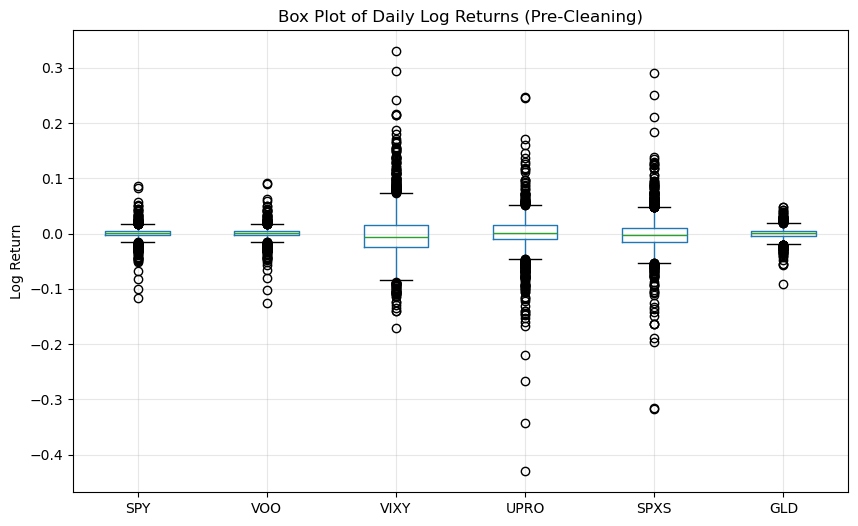

In [11]:
# --- Remove duplicate dates (just in case) ---
combined = combined[~combined.index.duplicated(keep='first')]

# --- Forward/backward fill small gaps (if any) ---
combined = combined.ffill().bfill()

# --- Recompute returns after filling ---
returns = np.log(combined / combined.shift(1)).dropna()
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
returns.boxplot()
plt.title("Box Plot of Daily Log Returns (Pre-Cleaning)")
plt.ylabel("Log Return")
plt.grid(True, alpha=0.3)
plt.show()


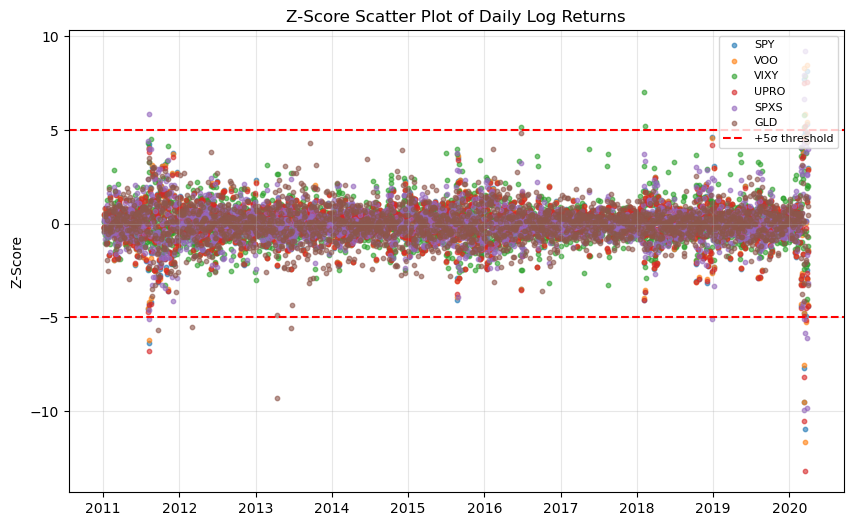

In [12]:
import numpy as np

# Compute z-scores
z_scores = (returns - returns.mean()) / returns.std()

plt.figure(figsize=(10, 6))
for col in z_scores.columns:
    plt.scatter(z_scores.index, z_scores[col], s=10, alpha=0.6, label=col)

plt.axhline(5, color='red', linestyle='--', label='+5σ threshold')
plt.axhline(-5, color='red', linestyle='--')
plt.title("Z-Score Scatter Plot of Daily Log Returns")
plt.ylabel("Z-Score")
plt.legend(loc='upper right', fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
print("Summary statistics of returns:") 
print(returns.describe()) 
print("\nTop absolute return values (potential outliers):") 
print(returns.abs().max().sort_values(ascending=False)) 
z_scores = (returns - returns.mean()) / returns.std() 
clean_returns = returns[(z_scores.abs() < 5).all(axis=1)] 
print("Removed", len(returns) - len(clean_returns), "rows as outliers.")


Summary statistics of returns:
               SPY          VOO         VIXY         UPRO         SPXS  \
count  2325.000000  2325.000000  2325.000000  2325.000000  2325.000000   
mean      0.000365     0.000367    -0.002262     0.000617    -0.001746   
std       0.010609     0.010740     0.042093     0.032610     0.031867   
min      -0.115887    -0.124870    -0.170477    -0.429954    -0.317941   
25%      -0.003243    -0.003221    -0.024473    -0.009688    -0.015611   
50%       0.000599     0.000639    -0.005781     0.001761    -0.002008   
75%       0.005103     0.005141     0.015087     0.014931     0.009643   
max       0.086731     0.091087     0.330013     0.246592     0.291339   

               GLD  
count  2325.000000  
mean      0.000045  
std       0.009893  
min      -0.091905  
25%      -0.004887  
50%       0.000359  
75%       0.005047  
max       0.047874  

Top absolute return values (potential outliers):
UPRO    0.429954
VIXY    0.330013
SPXS    0.317941
VOO     0.12

Cleaned returns shape: (2306, 6)
               SPY          VOO         VIXY         UPRO         SPXS  \
count  2306.000000  2306.000000  2306.000000  2306.000000  2306.000000   
mean      0.000436     0.000436    -0.002915     0.000925    -0.001769   
std       0.009101     0.009117     0.039509     0.027412     0.027311   
min      -0.049977    -0.050852    -0.170477    -0.159367    -0.149107   
25%      -0.003182    -0.003171    -0.024360    -0.009583    -0.015586   
50%       0.000604     0.000645    -0.005793     0.001814    -0.002046   
75%       0.005075     0.005114     0.014569     0.014833     0.009547   
max       0.043906     0.043671     0.187949     0.125202     0.138192   

               GLD  
count  2306.000000  
mean      0.000139  
std       0.009318  
min      -0.048145  
25%      -0.004810  
50%       0.000364  
75%       0.005045  
max       0.043231  


<Axes: title={'center': 'Cleaned Daily Log Returns'}, xlabel='Date'>

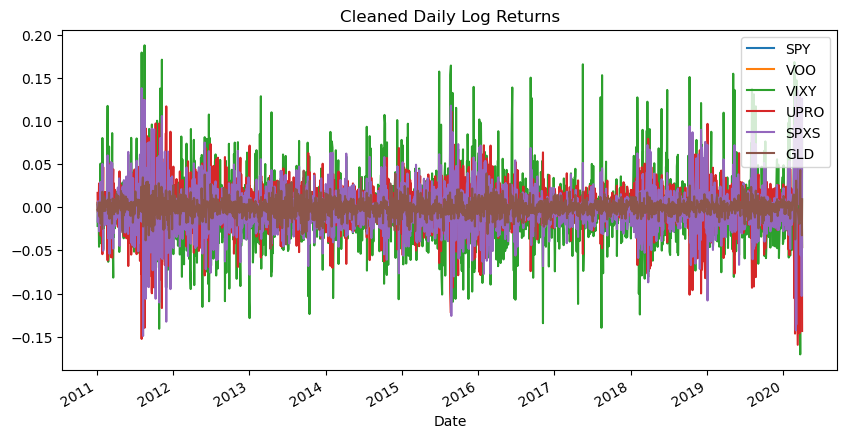

In [14]:
print("Cleaned returns shape:", clean_returns.shape)
print(clean_returns.describe())

# Check that all tickers are still aligned
assert all(clean_returns.notna().all()), "NaNs remain after cleaning!"

# Plot to visually inspect after cleaning
clean_returns.plot(title="Cleaned Daily Log Returns", figsize=(10,5))


Now that we have our data, it is important to begin to use it to make assumptions and observations. We will implement a multivariate GARCH and HAR model to allow us to at the very least have a starting point for this analysis. 

In [16]:
# --- Branch 1: Standard realized volatility ---
rv_spy = clean_returns['SPY'] ** 2

# Predictors: lagged squared returns from all assets
rv_all = clean_returns ** 2
rv_d = rv_all.shift(1).add_suffix('_d')
rv_w = rv_all.rolling(window=5).mean().shift(1).add_suffix('_w')
rv_m = rv_all.rolling(window=22).mean().shift(1).add_suffix('_m')

X = pd.concat([rv_d, rv_w, rv_m], axis=1)
data_static = pd.concat([rv_spy, X], axis=1).dropna()
data_static.columns = ['rv_spy'] + list(X.columns)

print(f"Branch 1 data shape: {data_static.shape}")


Branch 1 data shape: (2284, 19)


In [17]:
import statsmodels.api as sm

y_static = data_static['rv_spy']
X_static = sm.add_constant(data_static.drop(columns='rv_spy'))

har_static = sm.OLS(y_static, X_static).fit()
print(har_static.summary())


                            OLS Regression Results                            
Dep. Variable:                 rv_spy   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     44.53
Date:                Wed, 29 Oct 2025   Prob (F-statistic):          1.51e-134
Time:                        13:54:28   Log-Likelihood:                 16513.
No. Observations:                2284   AIC:                        -3.299e+04
Df Residuals:                    2265   BIC:                        -3.288e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.409e-05   8.39e-06      1.681      0.0

In [18]:
# --- Branch 2: Rolling realized volatility (5-day) ---
rv_spy_roll = clean_returns['SPY'].rolling(window=5).var().dropna()


In [19]:
# Create lagged predictors for all assets
rv_all = clean_returns ** 2
rv_d = rv_all.shift(1).add_suffix('_d')
rv_w = rv_all.rolling(window=5).mean().shift(1).add_suffix('_w')
rv_m = rv_all.rolling(window=22).mean().shift(1).add_suffix('_m')

X_roll = pd.concat([rv_d, rv_w, rv_m], axis=1)

# Align with target
data_roll = pd.concat([rv_spy_roll, X_roll], axis=1).dropna()
data_roll.columns = ['rv_spy_roll'] + list(X_roll.columns)

print(f"Branch 2 data shape: {data_roll.shape}")


Branch 2 data shape: (2284, 19)


In [20]:
y_roll = data_roll['rv_spy_roll']
X_roll = sm.add_constant(data_roll.drop(columns='rv_spy_roll'))

har_roll = sm.OLS(y_roll, X_roll).fit()
print(har_roll.summary())


                            OLS Regression Results                            
Dep. Variable:            rv_spy_roll   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     559.7
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:54:28   Log-Likelihood:                 18962.
No. Observations:                2284   AIC:                        -3.789e+04
Df Residuals:                    2265   BIC:                        -3.778e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.605e-06   2.87e-06     -0.559      0.5

In [21]:
from sklearn.metrics import mean_squared_error

# Compare adjusted R²
print(f"Adj R² (static realized): {har_static.rsquared_adj:.4f}")
print(f"Adj R² (rolling realized): {har_roll.rsquared_adj:.4f}")

# (Optional) Out-of-sample comparison
split_idx = int(len(data_static) * 0.8)
train_static, test_static = data_static.iloc[:split_idx], data_static.iloc[split_idx:]

y_train, X_train = train_static['rv_spy'], sm.add_constant(train_static.drop(columns='rv_spy'))
y_test, X_test = test_static['rv_spy'], sm.add_constant(test_static.drop(columns='rv_spy'))
preds_static = sm.OLS(y_train, X_train).fit().predict(X_test)

rmse_static = np.sqrt(mean_squared_error(y_test, preds_static))
print(f"Out-of-sample RMSE (static realized): {rmse_static:.6f}")

# Do the same for rolling realized volatility
split_idx_roll = int(len(data_roll) * 0.8)
train_roll, test_roll = data_roll.iloc[:split_idx_roll], data_roll.iloc[split_idx_roll:]

y_train_r, X_train_r = train_roll['rv_spy_roll'], sm.add_constant(train_roll.drop(columns='rv_spy_roll'))
y_test_r, X_test_r = test_roll['rv_spy_roll'], sm.add_constant(test_roll.drop(columns='rv_spy_roll'))
preds_roll = sm.OLS(y_train_r, X_train_r).fit().predict(X_test_r)

rmse_roll = np.sqrt(mean_squared_error(y_test_r, preds_roll))
print(f"Out-of-sample RMSE (rolling realized): {rmse_roll:.6f}")


Adj R² (static realized): 0.2555
Adj R² (rolling realized): 0.8150
Out-of-sample RMSE (static realized): 0.000268
Out-of-sample RMSE (rolling realized): 0.000118


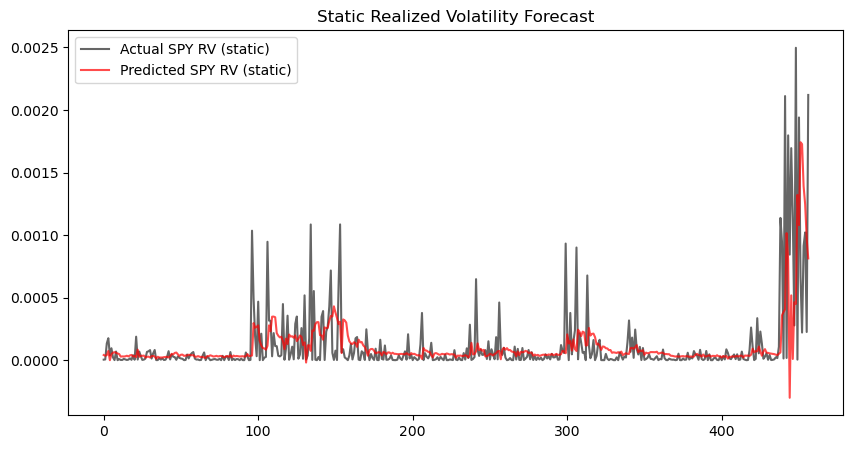

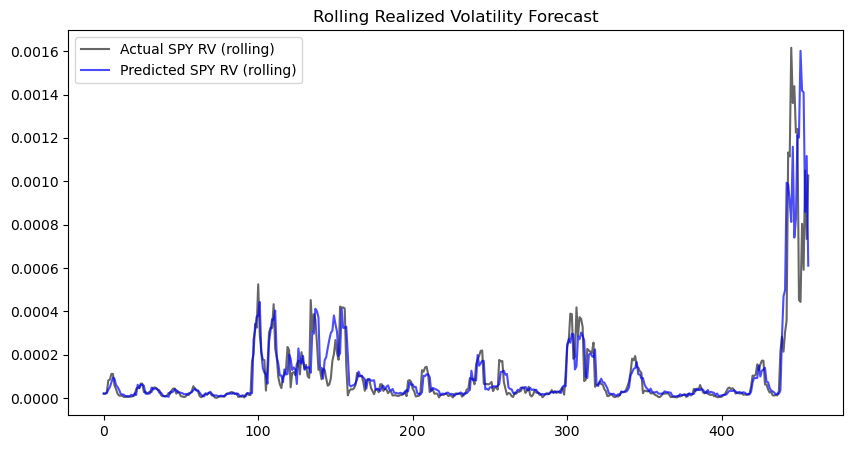

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual SPY RV (static)', color='black', alpha=0.6)
plt.plot(preds_static.values, label='Predicted SPY RV (static)', color='red', alpha=0.7)
plt.title('Static Realized Volatility Forecast')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_r.values, label='Actual SPY RV (rolling)', color='black', alpha=0.6)
plt.plot(preds_roll.values, label='Predicted SPY RV (rolling)', color='blue', alpha=0.7)
plt.title('Rolling Realized Volatility Forecast')
plt.legend()
plt.show()


In [23]:
from arch import arch_model

# Rescale SPY returns to avoid optimizer warning
spy_returns_scaled = clean_returns['SPY'] * 100

am = arch_model(spy_returns_scaled, vol='GARCH', p=1, q=1, mean='Zero')
res = am.fit(disp='off')

# Conditional volatility, rescaled back
garch_vol = res.conditional_volatility / 100
garch_vol.name = 'garch_vol'

# Add GARCH vol to both static and rolling features
X_train['garch_vol'] = garch_vol.loc[X_train.index]
X_test['garch_vol'] = garch_vol.loc[X_test.index]

X_train_r['garch_vol'] = garch_vol.loc[X_train_r.index]
X_test_r['garch_vol'] = garch_vol.loc[X_test_r.index]


In [24]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Scale features
scaler_static = StandardScaler()
X_train_scaled = scaler_static.fit_transform(X_train)
X_test_scaled = scaler_static.transform(X_test)

scaler_roll = StandardScaler()
X_train_r_scaled = scaler_roll.fit_transform(X_train_r)
X_test_r_scaled = scaler_roll.transform(X_test_r)

# GBM static
gbm_static = HistGradientBoostingRegressor(max_depth=5, learning_rate=0.05, random_state=42)
gbm_static.fit(X_train_scaled, y_train)
gbm_preds_static = gbm_static.predict(X_test_scaled)

# GBM rolling
gbm_roll = HistGradientBoostingRegressor(max_depth=5, learning_rate=0.05, random_state=42)
gbm_roll.fit(X_train_r_scaled, y_train_r)
gbm_preds_roll = gbm_roll.predict(X_test_r_scaled)

# Evaluate
rmse_gbm_static = np.sqrt(mean_squared_error(y_test, gbm_preds_static))
rmse_gbm_roll = np.sqrt(mean_squared_error(y_test_r, gbm_preds_roll))
print(f"GBM RMSE (static): {rmse_gbm_static:.6f}")
print(f"GBM RMSE (rolling): {rmse_gbm_roll:.6f}")


GBM RMSE (static): 0.000257
GBM RMSE (rolling): 0.000097


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Reshape for LSTM: (samples, timesteps=1, features)
X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3d = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_r_3d = X_train_r_scaled.reshape((X_train_r_scaled.shape[0], 1, X_train_r_scaled.shape[1]))
X_test_r_3d = X_test_r_scaled.reshape((X_test_r_scaled.shape[0], 1, X_test_r_scaled.shape[1]))

# LSTM static
lstm_static = Sequential([
    LSTM(64, input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.2),
    Dense(1)
])
lstm_static.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_static.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[es], verbose=0)
lstm_preds_static = lstm_static.predict(X_test_3d).flatten()

# LSTM rolling
lstm_roll = Sequential([
    LSTM(64, input_shape=(1, X_train_r_scaled.shape[1])),
    Dropout(0.2),
    Dense(1)
])
lstm_roll.compile(optimizer='adam', loss='mse')
lstm_roll.fit(X_train_r_3d, y_train_r, epochs=100, batch_size=32, validation_split=0.1, callbacks=[es], verbose=0)
lstm_preds_roll = lstm_roll.predict(X_test_r_3d).flatten()

# Evaluate
rmse_lstm_static = np.sqrt(mean_squared_error(y_test, lstm_preds_static))
rmse_lstm_roll = np.sqrt(mean_squared_error(y_test_r, lstm_preds_roll))
print(f"LSTM RMSE (static): {rmse_lstm_static:.6f}")
print(f"LSTM RMSE (rolling): {rmse_lstm_roll:.6f}")


ImportError: cannot import name 'runtime_version' from 'google.protobuf' (/opt/anaconda3/lib/python3.12/site-packages/google/protobuf/__init__.py)

In [ ]:
# Weighted average: HAR, GBM, LSTM
weights = np.array([0.4, 0.3, 0.3])

hybrid_static = weights[0]*preds_static.values + weights[1]*gbm_preds_static + weights[2]*lstm_preds_static
hybrid_roll = weights[0]*preds_roll.values + weights[1]*gbm_preds_roll + weights[2]*lstm_preds_roll

rmse_hybrid_static = np.sqrt(mean_squared_error(y_test, hybrid_static))
rmse_hybrid_roll = np.sqrt(mean_squared_error(y_test_r, hybrid_roll))
print(f"Hybrid RMSE (static): {rmse_hybrid_static:.6f}")
print(f"Hybrid RMSE (rolling): {rmse_hybrid_roll:.6f}")


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual SPY RV (static)', color='black', alpha=0.6)
plt.plot(preds_static.values, label='HAR (static)', color='red', alpha=0.6)
plt.plot(gbm_preds_static, label='GBM (static)', color='orange', alpha=0.6)
plt.plot(lstm_preds_static, label='LSTM (static)', color='green', alpha=0.6)
plt.plot(hybrid_static, label='Hybrid (static)', color='purple', linestyle='--')
plt.title('Static Realized Volatility Forecast')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_r.values, label='Actual SPY RV (rolling)', color='black', alpha=0.6)
plt.plot(preds_roll.values, label='HAR (rolling)', color='blue', alpha=0.6)
plt.plot(gbm_preds_roll, label='GBM (rolling)', color='orange', alpha=0.6)
plt.plot(lstm_preds_roll, label='LSTM (rolling)', color='green', alpha=0.6)
plt.plot(hybrid_roll, label='Hybrid (rolling)', color='purple', linestyle='--')
plt.title('Rolling Realized Volatility Forecast')
plt.legend()
plt.show()
